# Learning neural networks within Jupyter Notebook (part 2/2)

Piotr Migdał 


[PiterPy \#5](https://piterpy.com/en), 2-3 Nov 2018, St Petersburg, Russia


Based on a beautiful dataset [Google Quickdraw](https://quickdraw.withgoogle.com/data), more about it: [Machine Learning for Visualization - Let’s Explore the Cutest Big Dataset](https://medium.com/@enjalot/machine-learning-for-visualization-927a9dff1cab) - Ian Johnson.

You need to:

* Keras 2.0 
* download `campfire.npy`, `fireplace.npy`, `lighter.npy`, `candle.npy`, `light bulb.npy` and `lightning.npy` to `data`
* [livelossplot](https://github.com/stared/livelossplot/) (`pip install livelossplot`)
* `pip install keras_sequential_ascii`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn.apionly as sns
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalMaxPool2D

from keras_sequential_ascii import sequential_model_to_ascii_printout
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## What's inside?

In [2]:
!ls data/

campfire.npy   fireplace.npy  lighter.npy
candle.npy     light bulb.npy lightning.npy


In [3]:
data_example = np.load("./data/campfire.npy")
data_example.shape

(133395, 784)

## Data loading

I.e. the boring part.

In [4]:
classes = ["campfire", "fireplace", "lighter",
           "candle", "light bulb", "lightning"]
size = 28
limit = 500

X_list = []

for c in classes:
    X_c = np.load("data/{}.npy".format(c))
    print("Loaded {} out of {} {}s".format(limit, X_c.shape[0], c))
    X_list.append(X_c[:limit])

X = np.concatenate(X_list)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded 500 out of 133395 campfires
Loaded 500 out of 155570 fireplaces
Loaded 500 out of 121260 lighters
Loaded 500 out of 141545 candles
Loaded 500 out of 120879 light bulbs
Loaded 500 out of 151560 lightnings


In [5]:
X.dtype

dtype('uint8')

In [6]:
X.shape

(3000, 784)

In [7]:
X = X.reshape(-1, size, size, 1)
X = X.astype('float32') / 255.

In [8]:
Y.dtype

dtype('int64')

In [9]:
X.shape

(3000, 28, 28, 1)

## Train-test split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## First, let's have a look

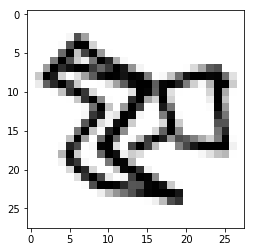

In [11]:
plt.imshow(X_train[5].reshape(28, 28), cmap='Greys');

In [12]:
Y_train[:5]

array([5, 0, 2, 3, 1])

In [13]:
def draw_examples(X, Y, classes, rows=6, scale=1):
    fig, axs = plt.subplots(rows, len(classes), figsize=(scale * len(classes), scale * rows))
    size = X.shape[1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        for i in range(rows):
            ax = axs[i, class_id]
            x = X_class[np.random.randint(len(classes))].reshape(size, size)
            ax.imshow(x, cmap='Greys', interpolation='none')
            ax.axis('off')

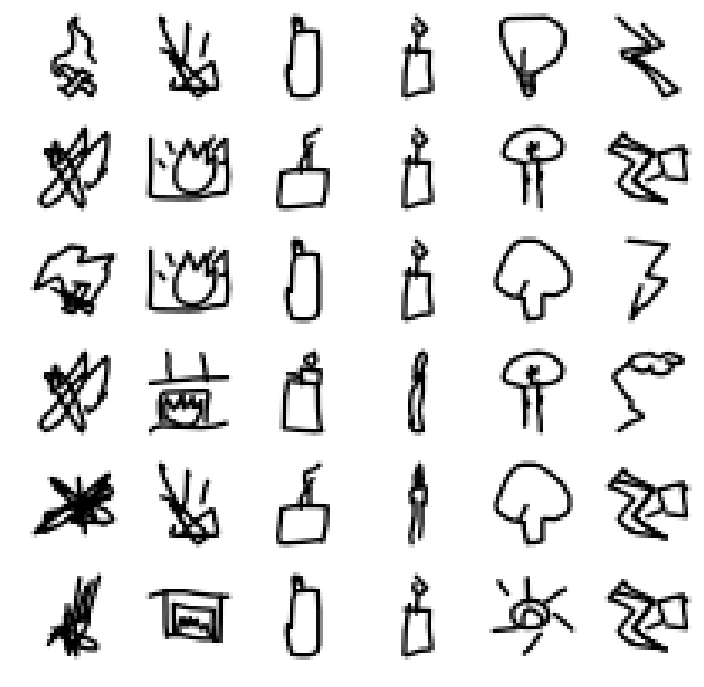

In [14]:
draw_examples(X_train, Y_train, classes, rows=6, scale=2)

## Per-class averages

Vide [this tweet](https://twitter.com/kcimc/status/902229612666658816)

In [15]:
def draw_class_averages(X, Y, classes, scale=2):
    fig, axs = plt.subplots(1, len(classes), figsize=(scale * len(classes), scale))
    size = X.shape[1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        ax = axs[class_id]
        x = X_class.mean(axis=0).reshape(size, size)
        ax.imshow(x, cmap='Greys', interpolation='none')
        ax.axis('off')

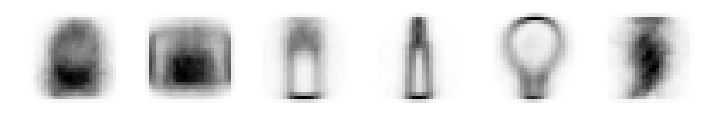

In [16]:
draw_class_averages(X_train, Y_train, classes)

## Logistic regression

In [17]:
model = Sequential()

model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------      4710   100.0%
             softmax   #####           6


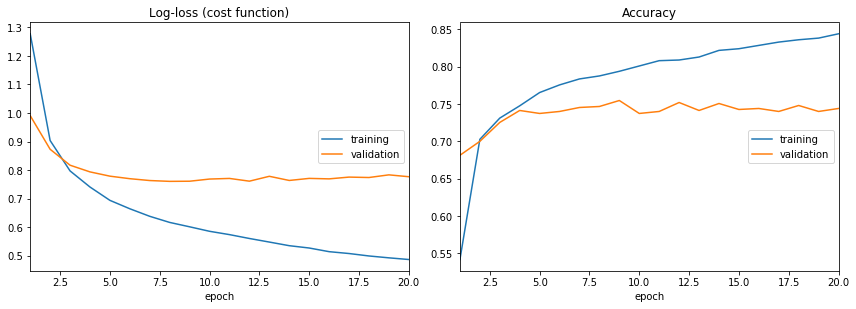

In [18]:
model.fit(X_train, Y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()])

## Old school neural network

In [19]:
model = Sequential()

model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------    100480    99.2%
             sigmoid   #####         128
               Dense   XXXXX -------------------       774     0.8%
             softmax   #####           6


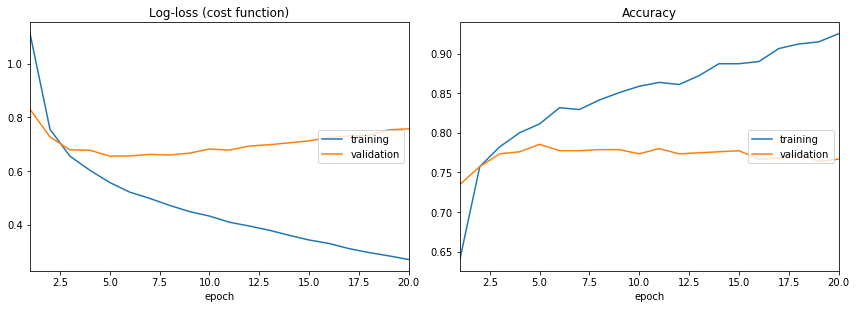

In [20]:
model.fit(X_train, Y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()])

## Create a convolutional neural network

In [21]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.5%
                relu   #####     26   26   16
              Conv2D    \|/  -------------------      2320     7.7%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640    15.5%
                relu   #####     10   10   32
              Conv2D    \|/  -------------------      9248    30.9%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   32
              Conv2D    \|/  -------------------      9248    30.9%
                relu   #####      2    2   32
             Flatten   ||||| -------------------         0     0.0%
              

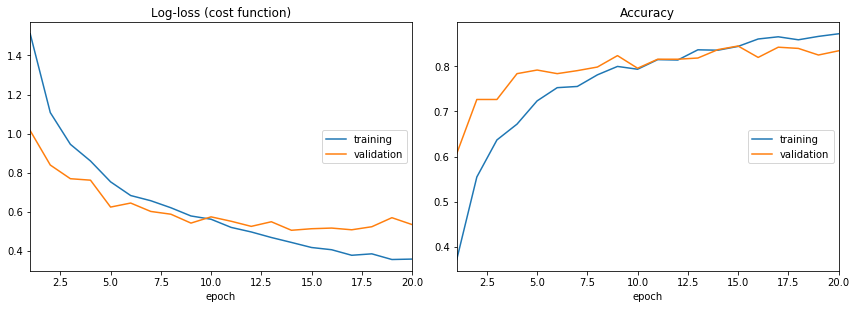

In [23]:
model.fit(X_train, Y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()])

## Side note - publish your package!

* Small scripts matter
* 10 min to make your package pip-installable
* Another 10 min to push it to PyPI
* No reason not share YOUR package!
* Or contribute to… mine ;)

## Let's see predictions

In [24]:
model.predict_classes(X_test[:3])

array([2, 2, 3])

In [25]:
model.predict(X_test[:3])

array([[1.6184093e-07, 1.9037133e-06, 7.4905330e-01, 2.5089473e-01,
        2.1465870e-05, 2.8458819e-05],
       [5.3520379e-09, 1.0913394e-07, 9.5040077e-01, 4.9596198e-02,
        2.0654077e-06, 8.5240248e-07],
       [8.0187374e-06, 2.0533068e-06, 3.0685675e-03, 9.9687386e-01,
        5.0776425e-06, 4.2382610e-05]], dtype=float32)

In [26]:
def plot_preditions(model, X, Y, classes, rows=6, only_wrong=False):
    
    # very greedy
    preds = model.predict(X)
    
    if only_wrong:
        incorrect = model.predict_classes(X) != Y
        preds = preds[incorrect]
        X = X[incorrect]
        Y = Y[incorrect]

    fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
    for i in range(rows):
        ax = axs[i, 0]
        ax.imshow(X[i].reshape(size, size),
                  cmap='Greys', interpolation='none')

        ax.axis('off')

        # pd.Series([int(Y_test[i] == j) for j in range(len(classes))], index=classes) \
        #  .plot('barh', ax=axs[i, 1], xlim=[0, 1], color='red')

        # pd.Series(preds[i], index=classes) \
        #  .plot('barh', ax=axs[i, 1], xlim=[0, 1], color='blue')
    
        pd.DataFrame({"pred": preds[i], "true": [int(Y[i] == j) for j in range(len(classes))]}, index=classes) \
          .plot(kind='barh', ax=axs[i, 1], xlim=[0, 1], stacked=True, legend=False)
        
    fig.tight_layout()

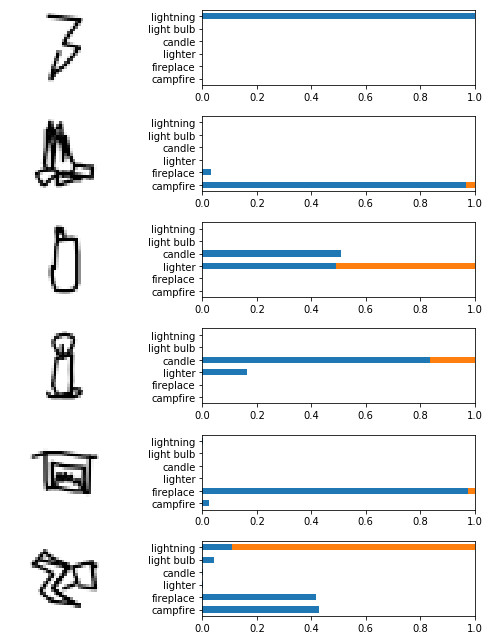

In [27]:
plot_preditions(model, X_train, Y_train, classes)

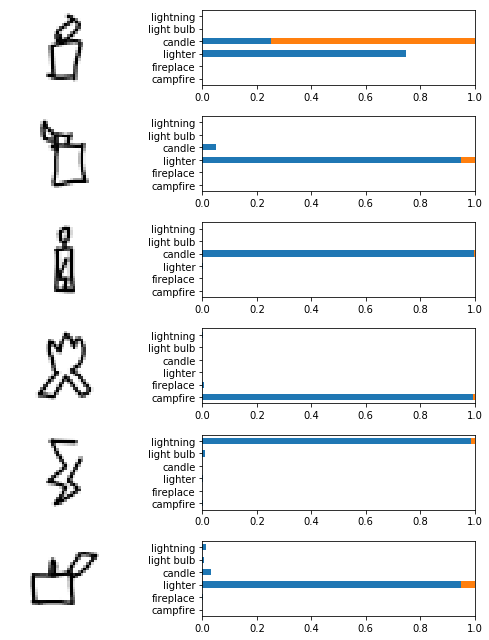

In [28]:
plot_preditions(model, X_test, Y_test, classes)

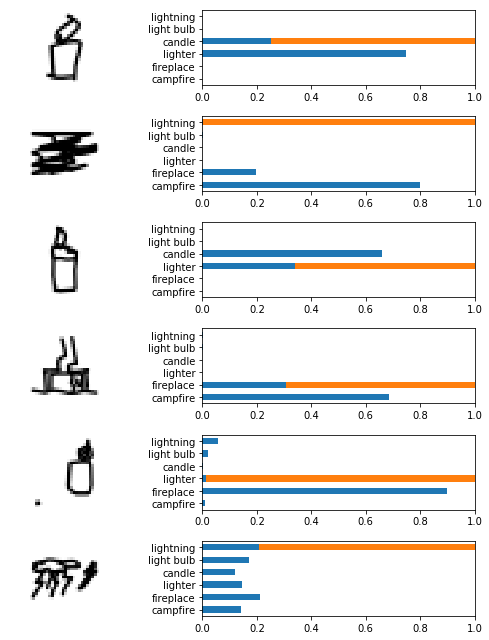

In [29]:
plot_preditions(model, X_test, Y_test, classes, only_wrong=True)

## Quantify confusion

In [30]:
preds = model.predict_classes(X_test)
cm = confusion_matrix(Y_test, preds)
cm

array([[128,   6,   1,   0,   0,   7],
       [ 23,  95,   0,   0,   0,   2],
       [  2,   4,  92,  23,   1,   1],
       [  0,   1,  17, 108,   0,   0],
       [  8,   4,   3,   1,  92,   5],
       [ 11,   3,   0,   0,   1, 111]])

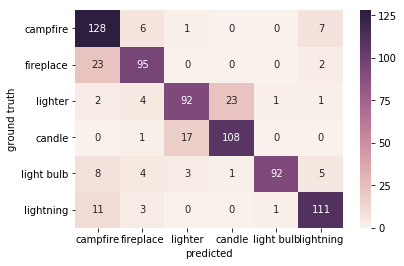

In [31]:
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_df.columns.name = "predicted"
cm_df.index.name = "ground truth"

sns.heatmap(cm_df, annot=True, fmt='d')

In [32]:
def confusion_image_matrix(model, X, Y, classes, size=28):
    confused = np.zeros((len(classes), len(classes), size, size), dtype='float32')
    Y_pred = model.predict_classes(X)
    for x, y_true, y_pred in zip(X, Y, Y_pred):
        confused[y_true, y_pred] = x[:, :, 0]

    fig, axs = plt.subplots(len(classes), len(classes), figsize=(2*len(classes), 2*len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax = axs[i, j]
            ax.imshow(confused[i, j], cmap='Greys', interpolation='none')
            ax.axis('off')

    fig.suptitle('predicted', fontsize=16)
    for ax, c in zip(axs[0], classes):
            ax.set_title(c)

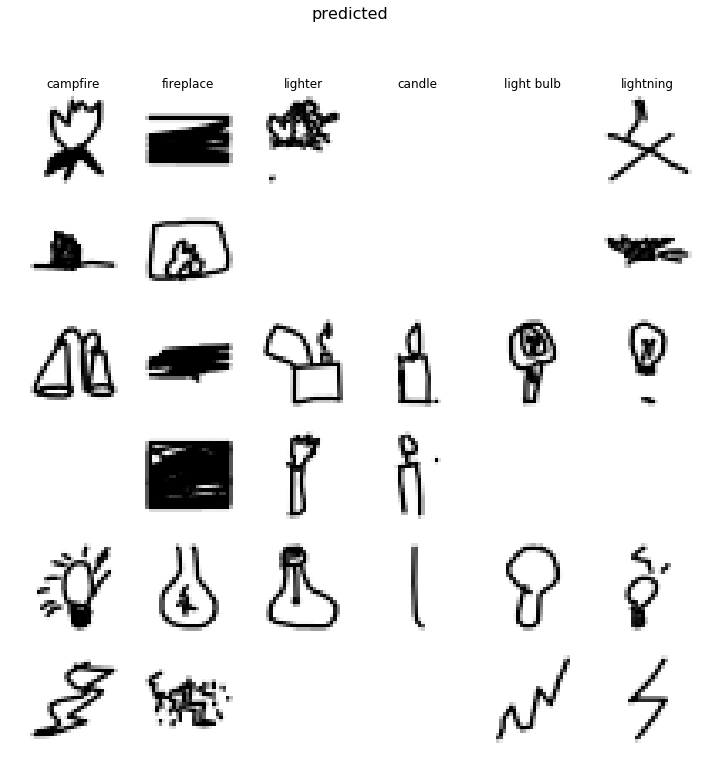

In [33]:
confusion_image_matrix(model, X_test, Y_test, classes)

## Thanks! / Спасибо!

Follow me on Twitter [@pmigdal](https://twitter.com/pmigdal) or my recent project [In Browser AI](https://inbrowser.ai/). Also: I co-organize [PyData Warsaw Conference](https://pydata.org/warsaw2018/) 19-20 Nov 2018.

If you want to learn more, some relevant blog posts:

* [Learning Deep Learning with Keras](https://p.migdal.pl/2017/04/30/teaching-deep-learning.html)
* [Keras or PyTorch as your first deep learning framework](https://deepsense.ai/keras-or-pytorch/) (previously with an inflammatory title *Don't learn TensorFlow - start with Keras or PyTorch instead*)
* [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/) with interactive code in Jupyter Notebook: https://www.kaggle.com/pmigdal/alien-vs-predator-images/kernels
* [Simple diagrams of convoluted neural networks](https://medium.com/inbrowserai/simple-diagrams-of-convoluted-neural-networks-39c097d2925b) - In Browser AI


![](imgs/avp_transfer_learning.png)